##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/hub/tutorials/bert_experts"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">View 在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/bert_experts.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/bert_experts.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/hub/tutorials/bert_experts.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
  <td><a href="https://tfhub.dev/s?q=experts%2Fbert"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型</a></td>
</table>

# TF-Hub 中的 BERT 专家模型

此 Colab 演示了如何执行以下操作：

- 从 [TensorFlow Hub](https://tfhub.dev) 加载已针对不同任务（包括 MNLI、SQuAD 和 PubMed）进行训练的 BERT 模型
- 使用匹配的预处理模型将原始文本词例化并转换为 ID
- 使用加载的模型从词例输入 ID 生成池化和序列输出
- 查看不同句子的池化输出的语义相似度

#### 注：此 Colab 应与 GPU 运行时一起运行

## 设置和导入

In [2]:
!pip install --quiet "tensorflow-text==2.8.*"

In [3]:
import seaborn as sns
from sklearn.metrics import pairwise

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

In [4]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

## 句子

我们从 Wikipedia 中获取一些句子以通过模型运行

In [5]:
sentences = [
  "Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.",
  "The album went straight to number one on the Norwegian album chart, and sold to double platinum.",
  "Among the singles released from the album were the songs \"Be My Lover\" and \"Hard To Stay Awake\".",
  "Riccardo Zegna is an Italian jazz musician.",
  "Rajko Maksimović is a composer, writer, and music pedagogue.",
  "One of the most significant Serbian composers of our time, Maksimović has been and remains active in creating works for different ensembles.",
  "Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum",
  "A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.",
  "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth.",
]

## 运行模型

我们将从 TF-Hub 加载 BERT 模型，使用 TF-Hub 中的匹配预处理模型将句子词例化，然后将词例化句子馈入模型。为了让此 Colab 变得快速而简单，我们建议在 GPU 上运行。

转到 **Runtime** → **Change runtime type** 以确保选择 **GPU**

In [6]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)
inputs = preprocess(sentences)
outputs = bert(inputs)

In [7]:
print("Sentences:")
print(sentences)

print("\nBERT inputs:")
print(inputs)

print("\nPooled embeddings:")
print(outputs["pooled_output"])

print("\nPer token embeddings:")
print(outputs["sequence_output"])

Sentences:
["Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.", 'The album went straight to number one on the Norwegian album chart, and sold to double platinum.', 'Among the singles released from the album were the songs "Be My Lover" and "Hard To Stay Awake".', 'Riccardo Zegna is an Italian jazz musician.', 'Rajko Maksimović is a composer, writer, and music pedagogue.', 'One of the most significant Serbian composers of our time, Maksimović has been and remains active in creating works for different ensembles.', 'Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum', 'A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.', "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth."]

BERT inputs:
{'input_word_

## 语义相似度

现在，我们看一下句子的 `pooled_output` 嵌入向量，并比较它们在句子中的相似程度。

In [8]:
#@title Helper functions

def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = pairwise.cosine_similarity(features)
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, cmap="Blues", cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

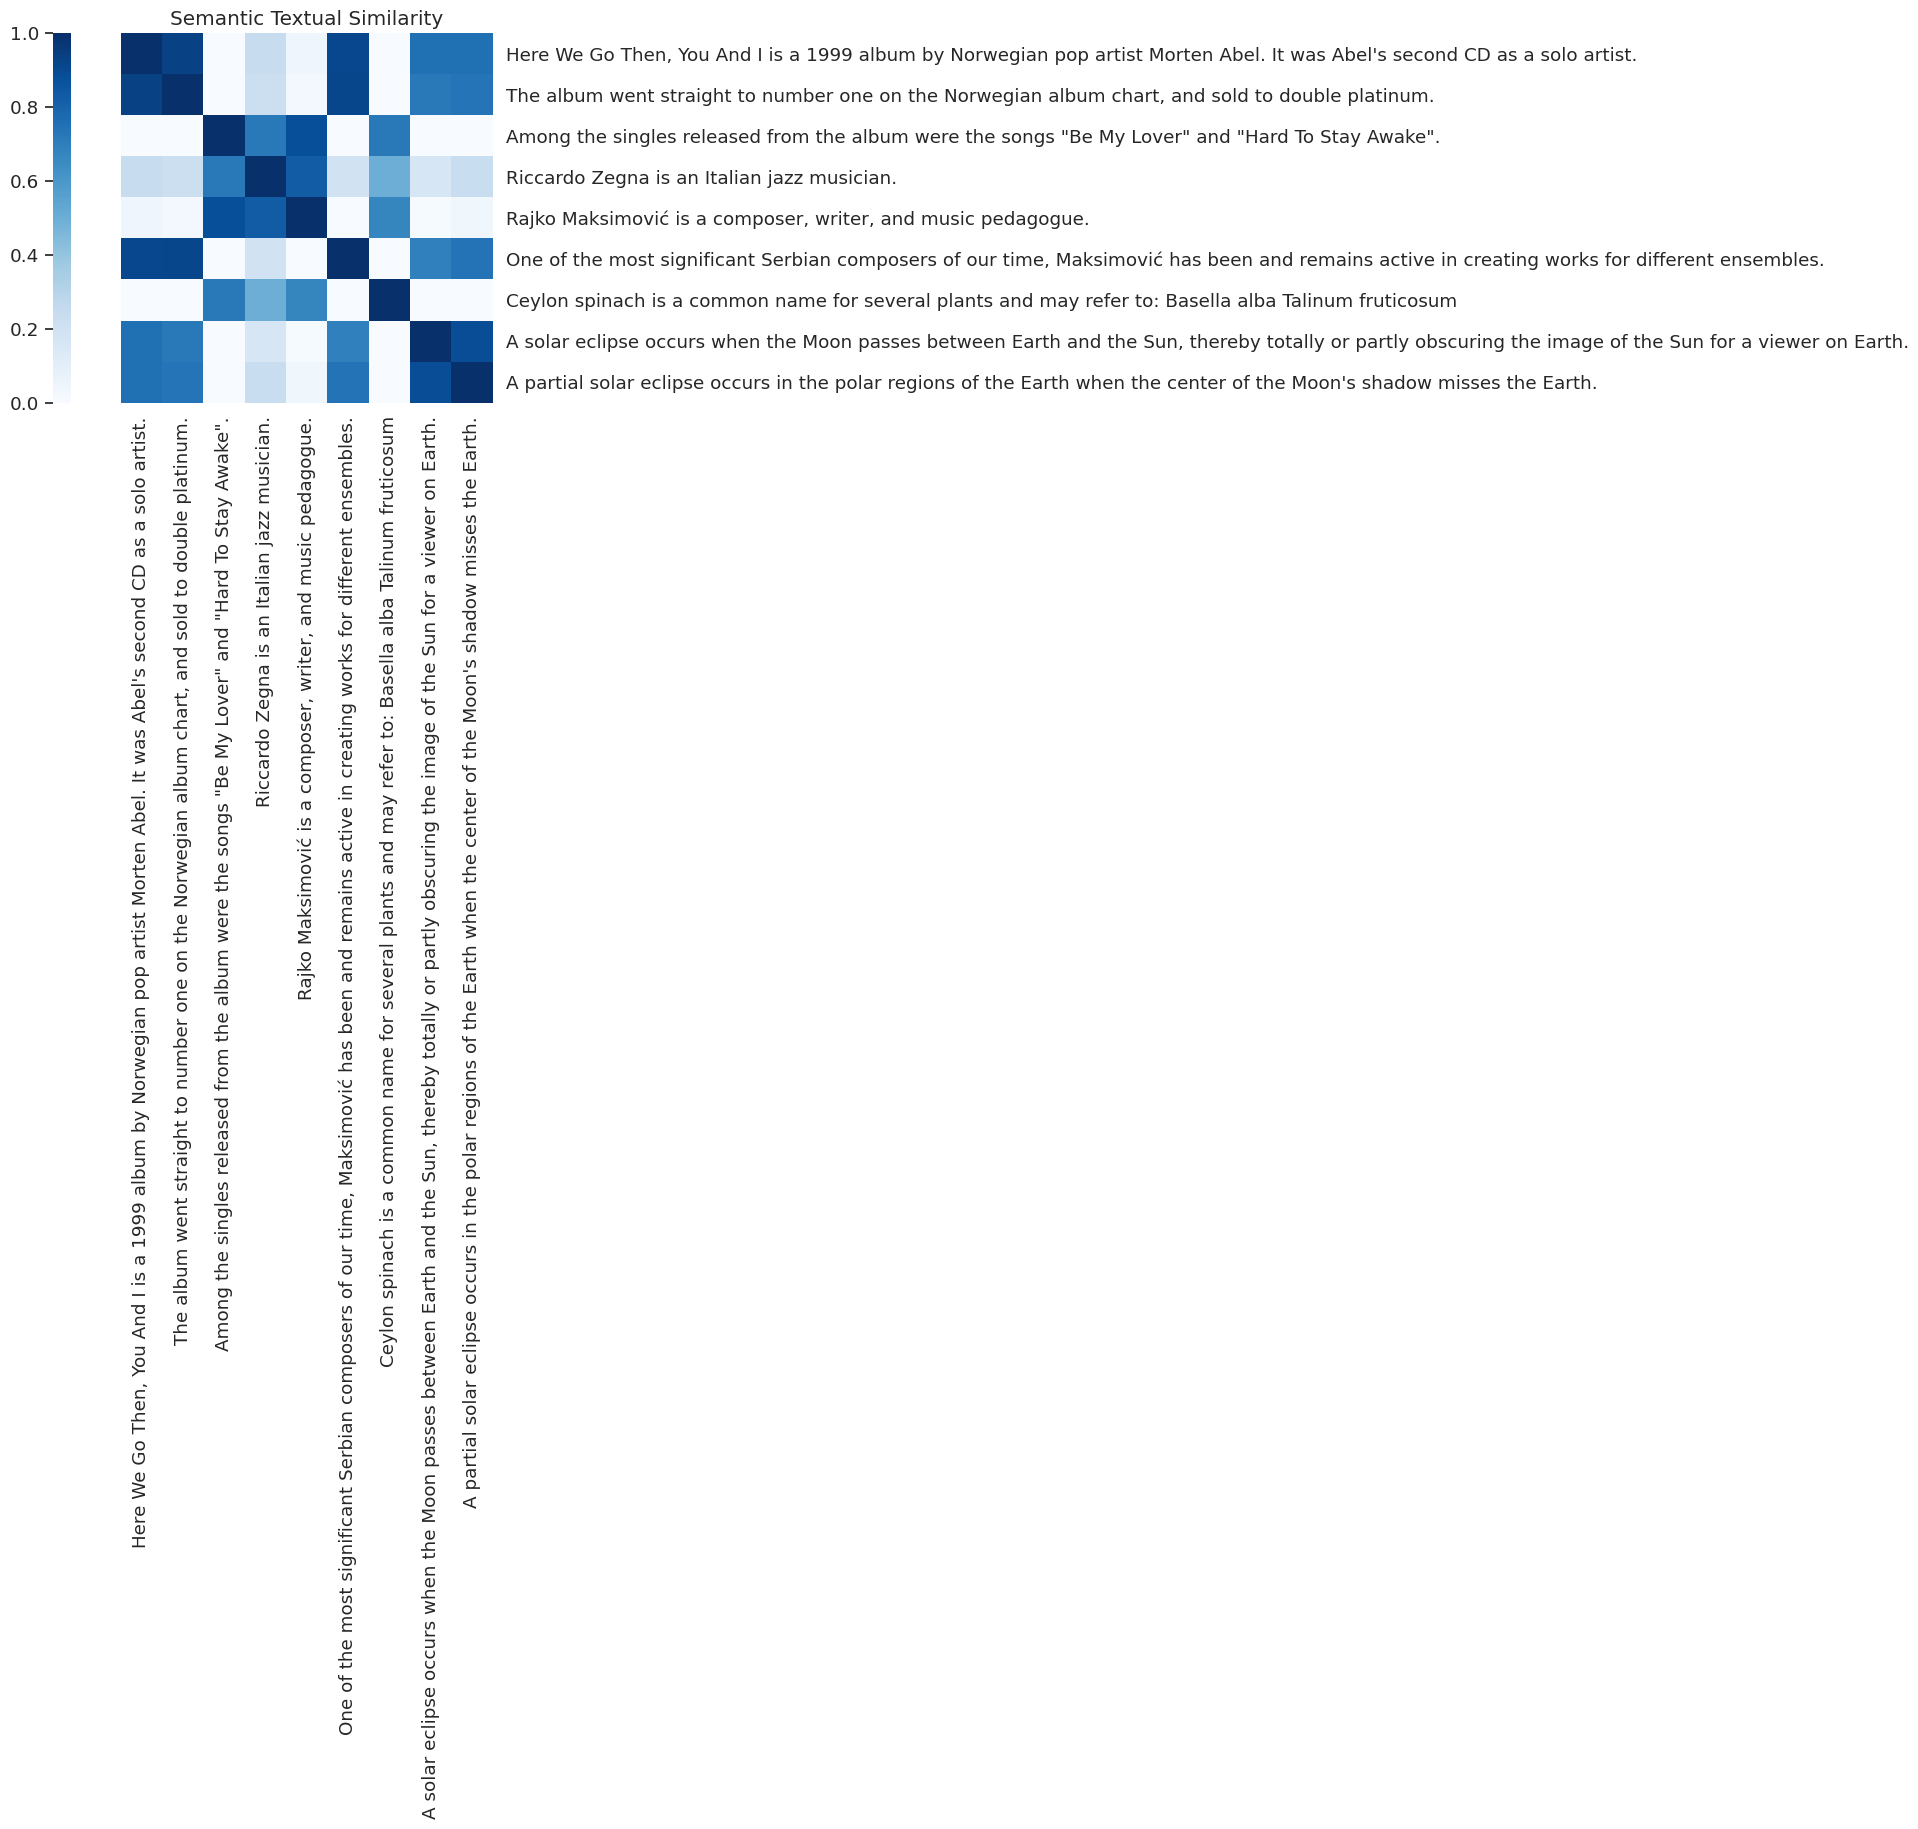

In [9]:
plot_similarity(outputs["pooled_output"], sentences)

## 了解详情

- 在 [TensorFlow Hub](https://tfhub.dev) 上查找更多 BERT 模型
- 此笔记本演示了使用 BERT 的简单推断，您可以在 [tensorflow.org/official_models/fine_tuning_bert](https://tensorflow.google.cn/official_models/fine_tuning_bert) 上找到有关微调 BERT 的更高级教程
- 我们仅使用一个 GPU 芯片运行模型，您可以在 [tensorflow.org/tutorials/distribute/save_and_load](https://tensorflow.google.cn/tutorials/distribute/save_and_load) 上详细了解如何使用 tf.distribute 加载模型